# Исследование объявлений о продаже квартир

<strong>Данные</strong>

Данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

По каждой квартире на продажу доступны два вида данных:
1. Вписаны пользователем
2. Получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

<strong>Задача</strong>

Установить параметры, определяющие рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

### Шаг 1. Изучение общей информации 

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Видим, что в таблице много данных, которые нужно предобработать, чтобы можно было с ними работать:
1. Есть пропуски:
 - ceiling_height, floors_total, kitchen_area, living_area - скорее всего, пользователь просто не указал/забыл эти данные
 - is_apartment, balcony - скорее всего, здесь пропуски можно заменить на "0" и "False", предполагая, что балконов нет и это не апартаменты
 - airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition - пропуски по этим столбцам скорее результат ошибки или недостатка данных, так как эти столбцы заполняются автоматически
2. Нужно поменять типы столбцов:
 - first_day_exposition - из object в datetime
 - floors_total, balcony, parks_around3000, ponds_around3000, days_exposition - из float в int, поскольку они все отражают кол-во сущностей, которые могут быть только целыми, например, мы не считаем половину водоема
 - is_apartment - из object в bool

### Шаг 2. Предобработка данных

Вначале заменим пропуски на 0 в столбцах булева типа

In [5]:
df['balcony'] = df['balcony'].fillna(0)
df['is_apartment'] = df['is_apartment'].fillna(0)

Из строк, в которых есть пропуски, нам понадобятся для расчетов только 7 из них:
- 'ceiling_height',
- 'floors_total',
- 'kitchen_area',
- 'locality_name',
- 'cityCenters_nearest',
- 'days_exposition',
- 'living_area'.\
Поэтому в остальных столбцах пропуски заменим просто на медиану, это не повлияет на конечный рез-тат

In [6]:
airports_nearest_median = df['airports_nearest'].median()
df['airports_nearest'] = df['airports_nearest'].fillna(airports_nearest_median)

In [7]:
parks_around3000_median = df['parks_around3000'].median()
df['parks_around3000'] = df['parks_around3000'].fillna(parks_around3000_median)

In [8]:
parks_nearest_median = df['parks_nearest'].median()
df['parks_nearest'] = df['parks_nearest'].fillna(parks_nearest_median)

In [9]:
ponds_around3000_median = df['ponds_around3000'].median()
df['ponds_around3000'] = df['ponds_around3000'].fillna(ponds_around3000_median)

In [10]:
ponds_nearest_median = df['ponds_nearest'].median()
df['ponds_nearest'] = df['ponds_nearest'].fillna(ponds_nearest_median)

Посмотрим процент пропусков в тех столбцах, которые будем использовать для расчетов

In [11]:
columns = ['ceiling_height', 'floors_total', 'kitchen_area', 'locality_name', 'cityCenters_nearest', 'days_exposition', 'living_area']
percent=0
for column in columns:
    percent = df[column].isnull().sum() / len(df[column])
    print(column, '-', '{:.1%}'.format(percent))

ceiling_height - 38.8%
floors_total - 0.4%
kitchen_area - 9.6%
locality_name - 0.2%
cityCenters_nearest - 23.3%
days_exposition - 13.4%
living_area - 8.0%


По столбцам 'floors_total' и 'locality_name' процент пропусков < 1%, если мы удалим эти строки, то это не сильно повлияет на конечный рез-тат

In [12]:
df.dropna(subset=['floors_total', 'locality_name'], inplace=True)

По столбцу 'ceiling_height' довольно высокий процент пропусков. При замене просто на медиану рискуем исказить реальную картину. Предположим, что высота потолков может зависеть от этажности дома. Например, в высокоэтажном доме сложно будет сделать высокие потолки, ну а в малоэтажном - почему бы и нет. Проверим, есть ли взаимосвязь 

In [13]:
df['ceiling_height'].corr(df['floors_total'])

-0.028586487736203064

Взаимосвязь близка к 0. В таком случае, заменим высоту потолков на медианное значение.

In [14]:
ceiling_height_median = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].fillna(ceiling_height_median)

Заменим пропуски в 'living_area' на медиану в зависимости от кол-ва комнат.

In [15]:
df['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

In [16]:
rooms = [3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12]
for room in rooms:
    median = df.loc[df['rooms'] == room, 'living_area'].median()
    df.loc[(df['rooms'] == room) & (df['living_area'].isnull()), 'living_area'] = median

In [17]:
df['rooms'].isnull().sum()

0

Теперь заменим пропуски в 'kitchen_area' на медианное значение в зависимости от 'living_area'

In [18]:
df['living_area'].describe()

count    23565.000000
mean        34.324899
std         21.722006
min          2.000000
25%         18.400000
50%         30.300000
75%         42.700000
max        409.700000
Name: living_area, dtype: float64

Создадим столбец с категориями квартир в зависимости от жилой площади:

In [19]:
def living_area_category(area):
    if area < 18.0:
        return 'маленькая'
    if area < 30.0:
        return 'средняя'
    if area < 42.0:
        return 'выше среднего'
    return 'большая'

In [20]:
df['living_area_category'] = df['living_area'].apply(living_area_category)

В зависимости от категории по площади квартиры, расчитаем медианы для каждой категории и присвоим эти значения в соответствующих пустых ячейках столбца 'kitchen_area'

In [21]:
categories = ['большая', 'средняя', 'выше среднего', 'маленькая']
for category in categories:
    median = df.loc[df['living_area_category'] == category, 'kitchen_area'].median()
    df.loc[(df['living_area_category'] == category) & (df['kitchen_area'].isnull()), 'kitchen_area'] = median

In [22]:
df['kitchen_area'].isnull().sum()

0

Поскольку в наших данных: Санкт-Петербург и ленинградская область. То скорее всего пропуски в столбце 'cityCenters_nearest' касаются пунктов, находящихся в Лен.области. Соответственно медиану стоит считать по области, не включая Петербург.

In [23]:
cityCenters_median = df.loc[df['locality_name'] != 'Санкт-Петербург', 'cityCenters_nearest'].median()

Посмотрим разницу значений медианы с Питером и без

In [24]:
cityCenters_median

30375.0

In [25]:
df['cityCenters_nearest'].median()

13096.5

Разница большая. Теперь заменим пропуски в 'cityCenters_nearest' на медиану по Ленобласти

In [26]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(cityCenters_median)

In [27]:
df['cityCenters_nearest'].isnull().sum()

0

Осталось избавиться от пропусков в 'days_exposition'. Процент пропусков по данному столбцу 13.4% - это не мало, но и не критично много. Также быстрота продажи зависит от многих показателей: района, цены на кв.м, от площади, ремонта, инфраструктуры. Это была бы отдельная аналитическая задача, поэтому просто заменим на медиану по столбцу

In [28]:
days_exposition_median = df['days_exposition'].median()

In [29]:
df['days_exposition'] = df['days_exposition'].fillna(days_exposition_median)

Проверим, остались ли пропуски

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        23565 non-null float64
cityCenters_nearest     23565 non-null float64
parks_around3000        23565 non-null float64
parks_nearest           23565 non-null float64
ponds_around3

Пропусков не осталось. Теперь поменяем типы данных в столбцах

In [31]:
df['balcony'] = df['balcony'].astype('int')
df['floors_total'] = df['floors_total'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df['days_exposition'] = df['days_exposition'].astype('int')

In [32]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [33]:
df['is_apartment'] = df['is_apartment'].astype('bool')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        23565 non-null float64
cityCenters_nearest     23565 non-null float64
parks_around3000        23565 non-null int64
parks_nearest           23565 non-null float64
ponds_around3

Типы данных поменяли

### Шаг 3. Проведение расчетов

Считаем цену квадратного метра:

In [35]:
df['square_meter_price'] = df['last_price']/df['total_area']

Добавляем день недели, месяц, год публикации объявления:

In [36]:
df['day_of_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).year

Создаем функцию, разделяющую этажи на категории. Применяем ф-ю к строкам таблицы методом apply, создаем новый столбец.

In [37]:
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [38]:
df['floor_category'] = df.apply(floor_category, axis = 1)

Создаем столбцы с соотношением площадей

In [39]:
df['living_total_area_ratio'] = df['living_area']/df['total_area']
df['kitchen_total_area_ratio'] = df['kitchen_area']/df['total_area']

In [40]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,living_area_category,square_meter_price,day_of_exposition,month_exposition,year_exposition,floor_category,living_total_area_ratio,kitchen_total_area_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,755.0,95,большая,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,502.0,81,средняя,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,574.0,558,выше среднего,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,234.0,424,большая,408176.100629,4,7,2015,другой,0.283019,0.069811
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,48.0,121,выше среднего,100000.000000,1,6,2018,другой,0.320000,0.410000


### Шаг 4. Проведение исследовательского анализа данных

In [41]:
import matplotlib.pyplot as plt

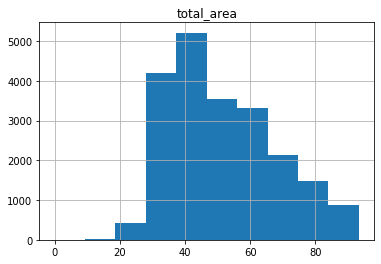

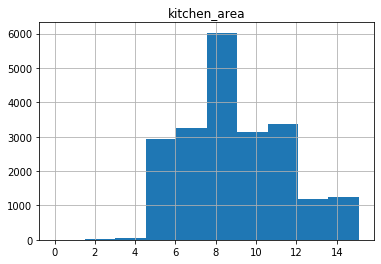

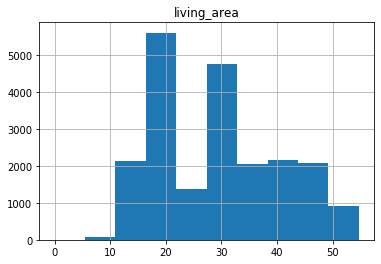

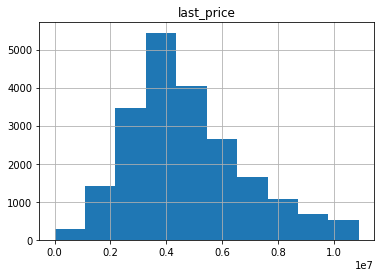

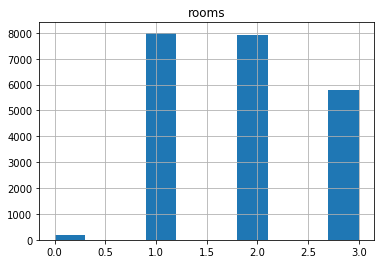

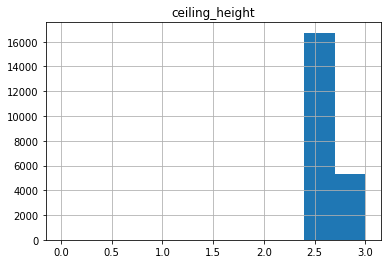

In [42]:
for element in ['total_area', 'kitchen_area', 'living_area', 'last_price', 'rooms', 'ceiling_height']:
    (
    df
    .hist(element, bins=10, range=(0, df[element].quantile(0.9)))
    )

В объявлениях преобладают квартиры с площадью от 38-45 кв.м, около 8-9 кв.м приходится на кухню, а жилая площадь в основном занимает 17-22 кв.м. В большинстве случаев, квартиры продают за 3.6-4.2 млн.руб. Квартиры, в основном, либо 1-комнатные, либо 2-комнатные. А высота потолков чаще всего составляет 2.4-2.7 метров.

Изучим время продажи квартиры

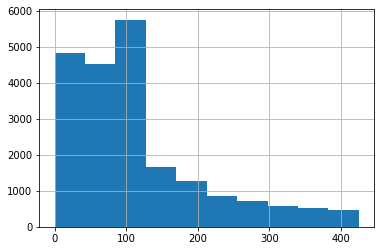

In [43]:
df['days_exposition'].hist(bins=10, range = (0, df['days_exposition'].quantile(0.9)))

In [44]:
df['days_exposition'].describe()

count    23565.000000
mean       169.203692
std        206.497729
min          1.000000
25%         45.000000
50%         95.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

Обычно продажа занимает около 3-х месяцев. Очень быстро прошла продажа за 1 день (не исключено, что такое могло произойти), аномально долго продавали 1580 дней, то есть около 4-х лет, возможно это системная ошибка.

In [45]:
desc = df[['total_area', 'days_exposition', 'rooms', 'ceiling_height', 'last_price']].describe()
desc

,total_area,days_exposition,rooms,ceiling_height,last_price
count,23565.000000,23565.000000,23565.000000,23565.000000,2.356500e+04
mean,60.322824,169.203692,2.070656,2.724530,6.540058e+06
std,35.657060,206.497729,1.078591,0.991026,1.091093e+07
min,12.000000,1.000000,0.000000,1.000000,1.219000e+04
25%,40.000000,45.000000,1.000000,2.600000,3.400000e+06
50%,52.000000,95.000000,2.000000,2.650000,4.646000e+06
75%,69.700000,198.000000,3.000000,2.700000,6.790000e+06
max,900.000000,1580.000000,19.000000,100.000000,7.630000e+08


Все выбросы считаем по формуле 3-й квартиль + 1,5 * межквартильный размах. По 'total_area' отбрасываем значения >= 113. По цене > 11875000. По показателям 'days_exposition', 'rooms', 'ceiling_height' отбрасывать значения не будем, поскольку это не ключевые параметры, определяющие стоимость квартир. Также отбросим все значения у которых total_area, living_area =0.

In [46]:
data_filtered = df.query('(total_area <= 113) & (last_price < 11875000) & (total_area != 0) & (living_area != 0)')

In [47]:
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,living_area_category,square_meter_price,day_of_exposition,month_exposition,year_exposition,floor_category,living_total_area_ratio,kitchen_total_area_ratio
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,502.0,81,средняя,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,574.0,558,выше среднего,92785.714286,3,8,2015,другой,0.612500,0.148214
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,48.0,121,выше среднего,100000.000000,1,6,2018,другой,0.320000,0.410000
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,502.0,55,маленькая,95065.789474,0,9,2018,другой,0.473684,0.299342
6,6,3700000.0,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,502.0,155,маленькая,99195.710456,3,11,2017,другой,0.284182,0.386059


Теперь посмотрим зависимость цены от разных факторов

In [48]:
data_filtered['last_price'].corr(data_filtered['total_area'])

0.6928209513084941

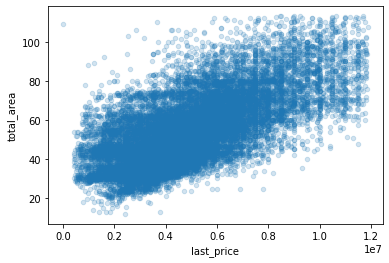

In [49]:
data_filtered.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2)

Зависимость высокая. Чем выше площадь - тем дороже квартира. Коэффициент корреляции довольно высокий

In [50]:
data_filtered['last_price'].corr(data_filtered['cityCenters_nearest'])

-0.5336653189904623

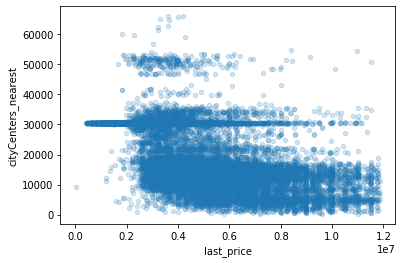

In [51]:
data_filtered.plot(x='last_price', y='cityCenters_nearest', kind='scatter', alpha=0.2)

Коэффициент корреляции отрицательный, что похоже на правду: чем меньше расстояние до центра - тем выше цена. Однако нет прямой зависимости, на квартиры, расположенные в одинаковой удаленности от центра совсем разные цены.

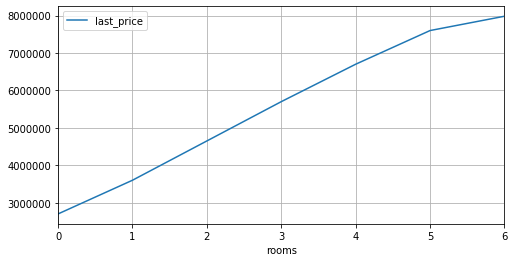

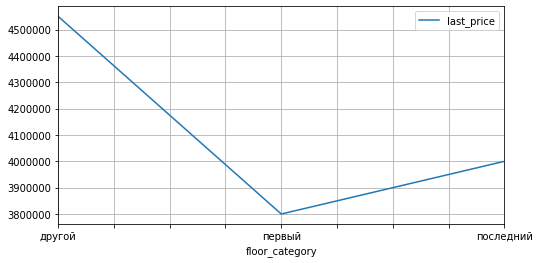

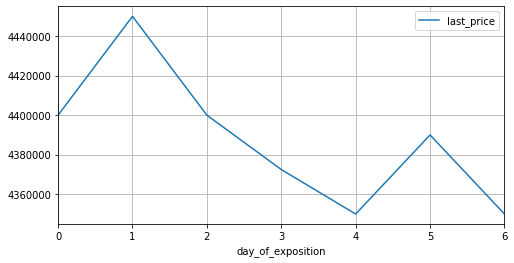

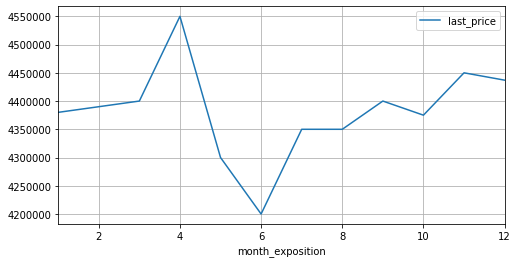

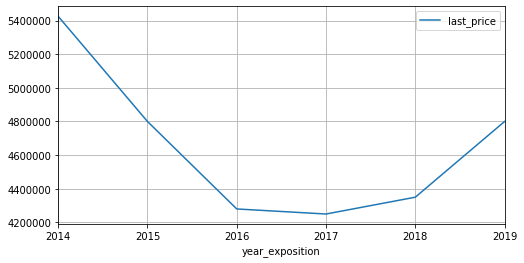

In [52]:
for element in ['rooms', 'floor_category', 'day_of_exposition', 'month_exposition', 'year_exposition']:
    (
        data_filtered
        .pivot_table(index=element, values='last_price', aggfunc='median')
        .plot(kind='line', grid=True, figsize=(8, 4))
    )
    

Чем больше комнат - тем выше цена. Квартиры на первом и последнем этажах стоят дешевле, чем в других. Квартиры, которые размещают по пятницам и воскресеньям стоят дешевле(интересно почему?). Размещаемые в апреле дороже, чем в остальных месяцах. Цена на квартиры упала после 2014г, к 2019 поднялась, но не достигла уровня 2014-го.

Найдем 10 населенных пунктов с наибольшим числом объявлений

In [53]:
(data_filtered.groupby('locality_name')
.agg({'rooms': 'count', 'square_meter_price': 'mean'})
.rename(columns = {'rooms': 'ads_counts', 'square_meter_price': 'mean_price_per_m'})
.sort_values(by='ads_counts', ascending=False).head(10)
)

,ads_counts,mean_price_per_m
locality_name,,
Санкт-Петербург,13531,105707.148121
посёлок Мурино,520,85673.259928
посёлок Шушары,436,78578.068204
Всеволожск,394,67222.431462
Пушкин,336,100462.063435
Колпино,335,75221.876295
посёлок Парголово,326,90332.263023
Гатчина,303,68664.035870
деревня Кудрово,298,92409.726322


Среди 10-ти населенных пунктов с самым большим количеством объявлений, самая высокая стоимость жилья в Санкт-Петербурге, а самая низкая в Выборге.

Определим центральную зону

In [54]:
#уберем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [55]:
data_st_peterburg = data_filtered.query('locality_name == "Санкт-Петербург"')

In [56]:
data_st_peterburg['cityCenters_nearest_km'] = data_st_peterburg['cityCenters_nearest']/1000

In [57]:
data_st_peterburg['cityCenters_nearest_km'] = data_st_peterburg['cityCenters_nearest_km'].round()

In [58]:
data_st_peterburg['last_price_mln'] = data_st_peterburg['last_price']/1000000

In [59]:
data_st_peterburg['price_km'] = data_st_peterburg['last_price_mln']/data_st_peterburg['cityCenters_nearest_km']

In [60]:
data_st_peterburg.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,square_meter_price,day_of_exposition,month_exposition,year_exposition,floor_category,living_total_area_ratio,kitchen_total_area_ratio,cityCenters_nearest_km,last_price_mln,price_km
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,92785.714286,3,8,2015,другой,0.612500,0.148214,14.0,5.196,0.371143
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,100000.000000,1,6,2018,другой,0.320000,0.410000,8.0,10.000,1.250000
7,5,7915000.0,71.6,2019-04-18,2,2.65,24,30.5,22,False,...,110544.692737,3,4,2019,другой,0.425978,0.263966,12.0,7.915,0.659583
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,88524.590164,6,2,2017,другой,0.714754,0.106557,15.0,5.400,0.360000
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,127525.252525,3,11,2017,другой,0.512626,0.214646,14.0,5.050,0.360714


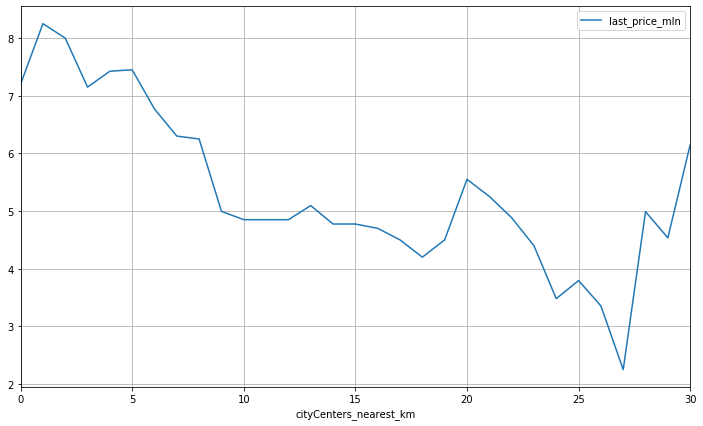

In [61]:
(data_st_peterburg
 .pivot_table(index='cityCenters_nearest_km', values='last_price_mln', aggfunc='median')
 .plot(kind='line', grid=True, legend=True, figsize=(12, 7))
)

В целом, наблюдается тенденция: чем дальше от центра, тем ниже цена. После 7-ми км от центра цена от 6.5 млн начинает резко падать и уже в 9-ти км квартиры стоят ниже 5 млн. На расстоянии 30-ти км от центра наблюдается подозрительный рост цен, возможно там какой-то элитный район.

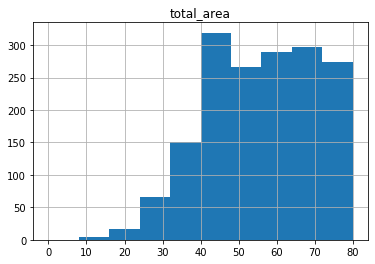

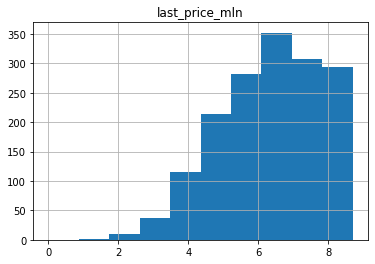

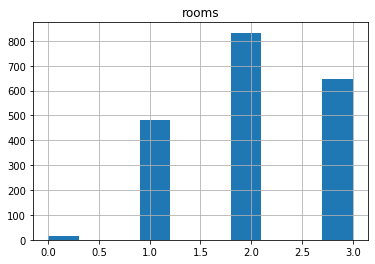

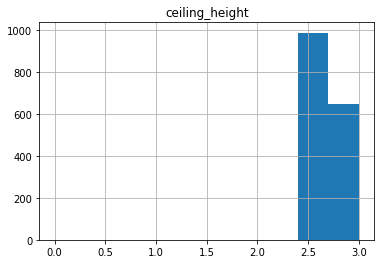

In [62]:
for element in ['total_area', 'last_price_mln', 'rooms', 'ceiling_height']:
    (data_st_peterburg
     .query('cityCenters_nearest_km <= 7')
     .hist(element, bins=10, range=(0, data_st_peterburg[element].quantile(0.9)))
    )

Квартиры в центре Питера - это в основном двушки площадью от 42 до 50 кв.м., стоят в районе 6-7 млн.руб., с высотой потолков 2.4 - 2.65м.

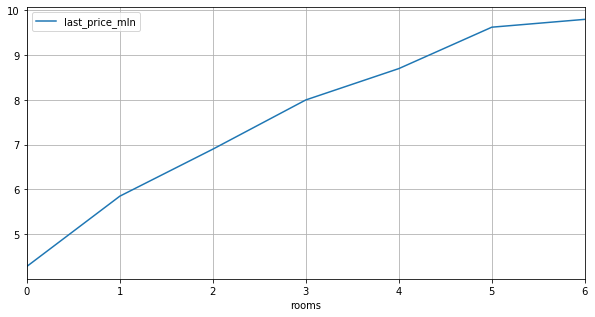

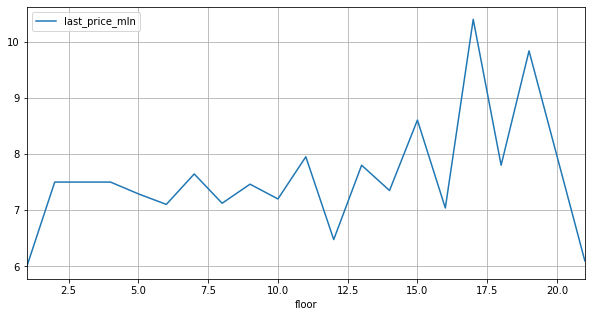

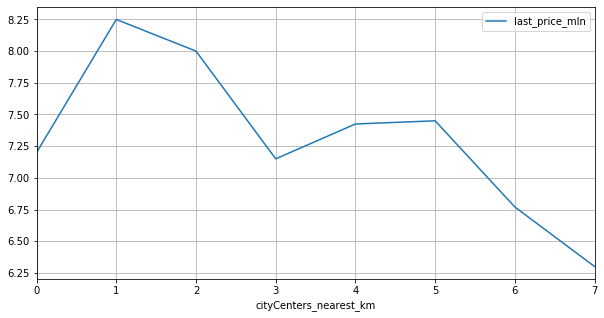

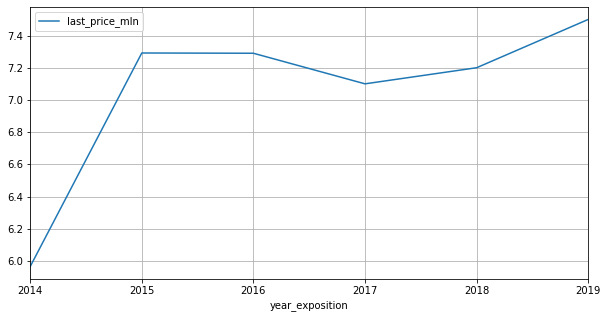

In [63]:
for element in ['rooms', 'floor', 'cityCenters_nearest_km', 'year_exposition']:
    (data_st_peterburg
     .query('cityCenters_nearest_km <= 7')
     .pivot_table(index=element, values='last_price_mln', aggfunc='median')
     .plot(kind='line', figsize=(10, 5), grid=True, legend=True)
    )

В центре чем больше комнат, тем выше цена, впрочем как и везде. От этажа зависит не сильно, но на самом первом и на самом последнем этаже можно найти варианты подешевле, тоже как и везде. Цены от 6 до 8 млн.р. А вот в зависимости от года, цена сильно выросла с 2014 по 2015 г. далее росла умеренно, с небольшим падением в 2017г. в отличие от цены по всей области, которая сильно упала после 2014г, с 2015 по 2016 она также падала.

### Шаг 5. Общий вывод

Больше всего на стоимость квартиры влияют площадь, число комнат и удаленность от центра(если это Питер, а если это область то там уже не сильно влияет на стоимость). Центром Питера считается зона в радиусе 7 км, цены на недвижимость там от 6 до 8 млн, в основном это 2-ки площадью до 50 кв.м. Квартиры на первых и последних этажах дешевле остальных, оно и понятно. Цены на недвижимость в целом по Ленинградской области сильно упали после 2014 года, но в центре Питера недвижимость постоянно дорожала.